In [45]:
import gensim
import nltk
nltk.download('wordnet')
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import pandas as pd
import re
stop_words = stopwords.words('english')
import pprint
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from nltk.stem import WordNetLemmatizer
from collections import Counter
from gensim.models import Phrases
from nltk.tokenize import sent_tokenize
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mihir\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_excel("factiva_parsed_raw.xlsx", sheet_name='Sheet1')

csv_file_path = 'factiva_wsj_parsed_raw.csv'
data.to_csv(csv_file_path, index=False)

In [3]:
lemmatizer = WordNetLemmatizer()
custom_stopwords = list(set(stop_words).union({}))
nltk.download('averaged_perceptron_tagger')

def filter_by_pos(tokens, pos_tags=['NN', 'NNS', 'NNP', 'NNPS']):  # Keep only nouns
    tagged_tokens = nltk.pos_tag(tokens)
    return [word for word, pos in tagged_tokens if pos in pos_tags]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mihir\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [1]:
dictionary = Dictionary(tokenized_docs)

NameError: name 'Dictionary' is not defined

In [4]:
def preprocess_text(text):
    
    text = re.sub(r'\s+', ' ', text)  

    
    text = re.sub(r'\S*@\S*\s?', '', text)  

    
    text = re.sub(r'\'', '', text)  

    
    text = re.sub(r'[^a-zA-Z]', ' ', text)  

    text = text.lower()  

    return text


In [5]:
def preprocess_data(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in custom_stopwords and len(token) > 3:
            result.append(token)
    return filter_by_pos(lemmatize_tokens(result))


In [6]:
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

In [118]:
processed_docs = data['article'].map(preprocess_text).map(preprocess_data)
bigram = Phrases(processed_docs, min_count=5, threshold=10)
trigram = Phrases(bigram[processed_docs], min_count=5, threshold=10)

def add_ngrams(tokens):
    return trigram[bigram[tokens]]

In [119]:

processed_docs = [add_ngrams(doc) for doc in processed_docs]
processed_docs = [doc for doc in processed_docs if len(doc) > 3] 

In [120]:

# Create Dictionary
id2word = corpora.Dictionary(processed_docs)

# Create Corpus
texts = processed_docs
corpus = [id2word.doc2bow(text) for text in texts]

# Build LDA Model
lda_model = LdaModel(corpus=corpus, 
                    id2word=id2word,
                    num_topics=10, 
                    random_state=100,
                    update_every=1,
                    chunksize=100,
                    passes=20,
                    alpha=0.1,
                    eta = 0.001,
                    per_word_topics=True)

# Keywords in the Topics
print(lda_model.print_topics())

KeyboardInterrupt: 

In [10]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.46856441881269195


In [91]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(best_lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.093673  0.0       1        1  52.068526
1     -0.093673  0.0       2        1  47.931474, topic_info=           Term         Freq        Total Category  logprob  loglift
6        barrel  5879.000000  5879.000000  Default  30.0000  30.0000
134       stock  3738.000000  3738.000000  Default  29.0000  29.0000
107  production  3996.000000  3996.000000  Default  28.0000  28.0000
259        bank  2240.000000  2240.000000  Default  27.0000  27.0000
204        opec  2351.000000  2351.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
140        time  1115.579892  1955.613890   Topic2  -5.1935   0.1741
3       analyst  1198.893104  2276.974883   Topic2  -5.1215   0.0939
151        week  1107.254006  2385.201684   Topic2  -5.2010  -0.0320
73     increase   917.991340  1535.120306   Topic2  -5.3884   0.2212
429     company  1046.289258  4410.350834   Topic2  -5.2576  -0.7033

[189 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
714       1  0.980641  acquisition
714       2  0.019515  acquisition
0         1  0.226452    agreement
0         2  0.773927    agreement
254       1  0.955097      airline
...     ...       ...          ...
3423      2  0.974251        yemen
158       1  0.975427        yield
158       2  0.025336        yield
159       1  0.728250         york
159       2  0.271812         york

[282 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [92]:
pyLDAvis.save_html(vis, 'lda_visualization.html')

In [93]:
def split_articles_into_sentences(articles):
    """
    Splits a list of articles into sentences.
    
    :param articles: List of whole articles.
    :return: List of sentences and a mapping from sentence index to article index.
    """
    sentences = []
    sentence_to_article_map = []
    for article_id, article in enumerate(articles):
        article_sentences = sent_tokenize(article)
        sentences.extend(article_sentences)
        sentence_to_article_map.extend([article_id] * len(article_sentences))
    return sentences, sentence_to_article_map


In [101]:
def get_example_sentences_for_topics(lda_model = best_lda_model,id2word = id2word, processed_sentences = processed_sentences, original_sentences = original_sentences, num_examples=10):
    """
    Returns example sentences for each topic, using the original (unprocessed) sentences.
    
    :param lda_model: Trained LDA model.
    :param id2word: Dictionary mapping word IDs to words.
    :param processed_sentences: List of processed sentences (used for LDA).
    :param original_sentences: List of original, unprocessed sentences.
    :param num_examples: Number of example sentences to return per topic.
    :return: Dictionary where keys are topic IDs and values are lists of example sentences.
    """
    # Convert processed sentences to BoW format
    sentence_corpus = [id2word.doc2bow(sent.split()) for sent in processed_sentences]
    
    topic_sentence_map = {i: [] for i in range(lda_model.num_topics)}
    for sent_id, sent_bow in enumerate(sentence_corpus):
        topic_dist = lda_model.get_document_topics(sent_bow)
        if topic_dist:  # Check if topic distribution is not empty
            try:
                # Get the dominant topic
                dominant_topic, dominant_prob = max(topic_dist, key=lambda x: x[1])
                
                # Validate dominant_topic
                if dominant_topic not in topic_sentence_map:
                    print(f"Warning: Invalid dominant_topic {dominant_topic} for sentence {sent_id}. Skipping.")
                    continue
                
                # Append the original sentence and its probability
                topic_sentence_map[dominant_topic].append((original_sentences[sent_id], dominant_prob))
            except Exception as e:
                print(f"Error processing sentence {sent_id}: {e}")
                print(f"topic_dist: {topic_dist}")
        else:
            # Handle cases where topic_dist is empty (e.g., document has no valid words)
            print(f"Warning: No topics inferred for sentence {sent_id}. Skipping.")
    
    # Sort sentences by topic probability and extract top examples
    example_sentences = {}
    for topic_id, sent_list in topic_sentence_map.items():
        sorted_sentences = sorted(sent_list, key=lambda x: x[1], reverse=True)  # Sort by probability
        example_sentences[topic_id] = [sent for sent, prob in sorted_sentences[:num_examples]]
    
    return example_sentences



In [102]:
def create_sentence_mapping(articles):
    """
    Splits a list of articles into sentences and creates a mapping between processed and original sentences.
    
    :param articles: List of whole articles.
    :return: List of processed sentences, list of original sentences, and a mapping from sentence index to article index.
    """
    processed_sentences = []  # Processed sentences (stop words removed, tokenized, etc.)
    original_sentences = []   # Original, unprocessed sentences
    sentence_to_article_map = []  # Maps sentence index to article index

    for article_id, article in enumerate(articles):
        article_sentences = sent_tokenize(article)  # Split article into sentences
        for sent in article_sentences:
            original_sentences.append(sent)  # Store original sentence
            processed_sent = preprocess_text(sent)  # Preprocess the sentence (e.g., remove stop words, tokenize)
            processed_sentences.append(processed_sent)
            sentence_to_article_map.append(article_id)
            
    return processed_sentences, original_sentences, sentence_to_article_map

In [103]:


articles = data["article"]  # List of your whole articles
processed_sentences, original_sentences, _ = create_sentence_mapping(articles)
example_sentences = get_example_sentences_for_topics(best_lda_model, id2word, processed_sentences, original_sentences, num_examples=10)

# Print example sentences for each topic
for topic_id, examples in example_sentences.items():
    print(f"Topic {topic_id}:")
    for example in examples:
        print(f" - {example}")
    print("\n")

Topic 0:
 - Forward Guidance
 Wednesday (all times ET)
 12 p.m.: Atlanta Fed 's Bostic, Chicago Fed 's Evans, Dallas Fed's Kaplan and Philadelphia Fed 's Harker speak on economy and monetary policy at virtual event on racism and the economy; Philadelphia Fed 's Harker speaks virtually on economic outlook at Women in Housing and Finance event
 1:10 p.m.: European Central Bank 's Lagarde gives online speech
 2 p.m.: Federal Reserve releases beige book report on U.S. economic conditions
 Thursday
 12 p.m.: Bank of England 's Bailey speaks on the financial sector and climate change risks at virtual Green Swan Conference
 12:30 p.m.: Atlanta Fed 's Bostic speaks at virtual launch of book on the workforce and economic mobility
 1 p.m.: Dallas Fed's Kaplan speaks at webinar on economy and monetary policy hosted by Rice University Jones Graduate School of Business
 1:50 p.m.: Philadelphia Fed 's Harker speaks at virtual launch of book on the workforce and economic mobility
 3:05 p.m.: Fed's Qu

In [104]:
def create_html_output(example_sentences, output_file="lda_example_output.html"):
    """
    Creates an HTML file to display the topics and their example sentences.
    
    :param example_sentences: Dictionary where keys are topic IDs and values are lists of example sentences.
    :param output_file: Name of the output HTML file.
    """
    # Start building the HTML content
    html_content = """
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>LDA Topic Output</title>
        <style>
            body { font-family: Arial, sans-serif; margin: 20px; }
            h1 { color: #333; }
            h2 { color: #555; }
            ul { list-style-type: none; padding: 0; }
            li { background: #f9f9f9; margin: 5px 0; padding: 10px; border-radius: 5px; }
        </style>
    </head>
    <body>
        <h1>LDA Topic Output</h1>
    """

    # Add topics and example sentences to the HTML content
    for topic_id, examples in example_sentences.items():
        html_content += f"""
        <h2>Topic {topic_id}</h2>
        <ul>
        """
        for example in examples:
            html_content += f"<li>{example}</li>"
        html_content += """
        </ul>
        """

    # Close the HTML content
    html_content += """
    </body>
    </html>
    """

    # Write the HTML content to a file
    with open(output_file, "w", encoding="utf-8") as file:
        file.write(html_content)

    print(f"HTML file saved as {output_file}")
create_html_output(example_sentences, output_file="lda_examples_output.html")

HTML file saved as lda_examples_output.html


In [105]:
file1 = "lda_visualization.html"
merged_file = "merged_lda.html"

# Load the previously generated DataFrame
df = pd.read_csv("lda_sentence_analysis.csv")  # Ensure this file exists

# Convert DataFrame to HTML table
df_html = df.to_html(index=False, escape=False)  # `escape=False` keeps special characters

# Read content of the first HTML file
with open(file1, "r", encoding="utf-8") as f1:
    content1 = f1.read()

# Merge content with the DataFrame as an HTML table
merged_content = f"""
<!DOCTYPE html>
<html>
<head>
    <title>LDA Analysis</title>
    <style>
        table {{
            width: 100%;
            border-collapse: collapse;
        }}
        th, td {{
            border: 1px solid black;
            padding: 8px;
            text-align: left;
        }}
        th {{
            background-color: #f2f2f2;
        }}
    </style>
</head>
<body>
    <section>
        {content1}
    </section>
    <section>
        <h2>LDA Sentence Analysis</h2>
        {df_html}
    </section>
</body>
</html>
"""

# Write to a new merged file
with open(merged_file, "w", encoding="utf-8") as f_out:
    f_out.write(merged_content)

print(f"Merged HTML saved as {merged_file}")

Merged HTML saved as merged_lda.html


In [106]:

topics_sentences = example_sentences

dictionary = id2word

# Function to get topic distribution for a sentence
def get_topic_weights(sentence, model, dictionary):
    bow = dictionary.doc2bow(sentence.lower().split())  # Convert sentence to Bag of Words
    return model.get_document_topics(bow, minimum_probability=0.0)  # Get topic probabilities

# Function to get word weights for a given topic
def get_word_weights(topic_id, model):
    return dict(model.show_topic(topic_id, topn=10))  # Get top words for the topic

# Generate results
output_data = []

for topic_id, sentences in topics_sentences.items():
    word_weights = get_word_weights(topic_id, best_lda_model)  # Get word weights for the topic

    for sentence in sentences:
        topic_probs = get_topic_weights(sentence, best_lda_model, dictionary)
        topic_weight = dict(topic_probs).get(topic_id, 0.0)  # Get probability for this topic
        words = sentence.split()
        
        # Calculate individual word weights
        word_contributions = {word: word_weights.get(word, 0) for word in words}

        output_data.append([topic_id, sentence, topic_weight, word_contributions])

# Convert to DataFrame
df = pd.DataFrame(output_data, columns=["Topic ID", "Sentence", "Topic Weight", "Word Weights"])

def process_row(row):
    word_weights = row["Word Weights"]  # Dictionary of word weights
    filtered_weights = {word: weight for word, weight in word_weights.items() if weight > 0}  # Remove weight=0
    
    # Highlight words in the sentence
    highlighted_sentence = row["Sentence"]
    for word in filtered_weights:
        highlighted_sentence = highlighted_sentence.replace(word, f"<b>{word}</b>")

    return highlighted_sentence, filtered_weights

# Apply transformations to the DataFrame
df[["Sentence", "Word Weights"]] = df.apply(lambda row: process_row(row), axis=1, result_type="expand")
# Save to file
df.to_csv("lda_sentence_analysis.csv", index=False)
print("Output saved as 'lda_sentence_analysis.csv'")

Output saved as 'lda_sentence_analysis.csv'


In [107]:
import pandas as pd

def select_best_sentences(sentences_by_topic, model, dictionary, top_n=100):
    best_sentences = {i: [] for i in range(model.num_topics)}  # Ensure all topics exist

    for sentence in sentences:
        # Convert sentence to Bag of Words format
        bow = dictionary.doc2bow(sentence.lower().split())
        
        # Get topic probabilities for the sentence
        topic_probs = dict(model.get_document_topics(bow, minimum_probability=0.0))
        
        # Get the top `N` strongest topics for this sentence
        sorted_topics = sorted(topic_probs.items(), key=lambda x: x[1], reverse=True)

        # If no valid topic, skip sentence
        if not sorted_topics:
            continue

        # Assign the sentence to multiple strong topics (if possible)
        for topic_id, topic_weight in sorted_topics[:3]:  # Consider top 3 topics
            word_weights = dict(model.show_topic(topic_id, topn=50))
            sentence_word_weights = {word: word_weights.get(word, 0) for word in sentence.split()}
            sentence_score = sum(sentence_word_weights.values())  

            # Store only if the sentence has at least one relevant word
            if sentence_score > 0:
                best_sentences[topic_id].append((sentence, sentence_score, topic_weight))

    # Sort and select top `N` sentences per topic
    for topic_id in best_sentences:
        sorted_sentences = sorted(best_sentences[topic_id], key=lambda x: (x[1], x[2]), reverse=True)
        best_sentences[topic_id] = [s[0] for s in sorted_sentences[:top_n]]

    return best_sentences



In [108]:
best_sentences = select_best_sentences(original_sentences, best_lda_model, id2word, top_n=100)

# Convert to DataFrame for easy export
output_data = []
for topic_id, sentences in best_sentences.items():
    for sentence in sentences:
        output_data.append([topic_id, sentence])

df = pd.DataFrame(output_data, columns=["Topic ID", "Sentence"])


In [109]:
df

,Topic ID,Sentence
0,0,"Related\n * OPEC, Allies to Finalize Oil-Cut E..."
1,0,Mr. Chaturvedi said the Indian government will...
2,0,"Read More\n * Oil Prices Soar After OPEC, Alli..."
3,0,"In any case, America's most famous socialist h..."
4,0,The White House meeting comes six weeks after ...
5,1,The White House meeting comes six weeks after ...
6,1,"Read More\n * Oil Prices Soar After OPEC, Alli..."
7,1,"In any case, America's most famous socialist h..."
8,1,"Related\n * OPEC, Allies to Finalize Oil-Cut E..."
9,1,Mr. Chaturvedi said the Indian government will...


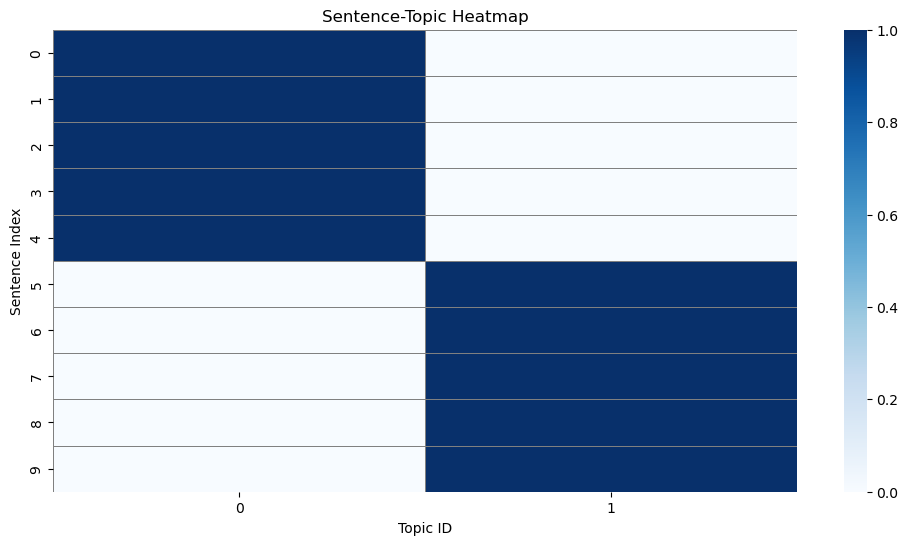

In [110]:


df.to_csv("filtered_best_sentences.csv", index=False)
df = pd.read_csv("filtered_best_sentences.csv")

# Assign a numerical index to each sentence
df["Sentence ID"] = range(len(df))

# Create a pivot table with Topics as columns and Sentences as rows
pivot_df = df.pivot(index="Sentence ID", columns="Topic ID", values="Sentence")

# Convert topic ID into categorical for better plotting
pivot_df = pivot_df.notnull().astype(int)  # Binary encoding: 1 if the sentence belongs to topic

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_df, cmap="Blues", linewidths=0.5, linecolor="gray")

plt.title("Sentence-Topic Heatmap")
plt.xlabel("Topic ID")
plt.ylabel("Sentence Index")
plt.show()

Training LDA for 2 topics...
Training LDA for 3 topics...
Training LDA for 4 topics...
Training LDA for 5 topics...
Training LDA for 6 topics...
Training LDA for 7 topics...
Training LDA for 8 topics...
Training LDA for 9 topics...
Training LDA for 10 topics...
Training LDA for 11 topics...
Training LDA for 12 topics...
Training LDA for 13 topics...
Training LDA for 14 topics...
Training LDA for 15 topics...
Training LDA for 16 topics...
Training LDA for 17 topics...
Training LDA for 18 topics...
Training LDA for 19 topics...


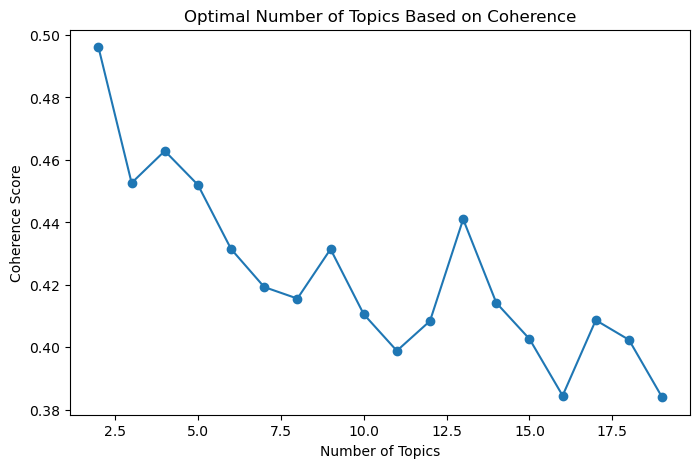

Best number of topics: 2


In [50]:
from gensim.models import CoherenceModel, LdaMulticore
import matplotlib.pyplot as plt
import numpy as np

def find_optimal_topics(dictionary, corpus, texts, start=2, limit=20, step=1, workers=4):
    """
    Finds the best number of topics based on coherence score.

    Parameters:
    - dictionary: Gensim Dictionary
    - corpus: Bag of Words representation of documents
    - texts: Tokenized sentences
    - start, limit, step: Range of topics to evaluate
    - workers: Number of CPU cores for parallel processing (default=4)

    Returns:
    - Best num_topics value
    """
    topic_range = range(start, limit, step)
    coherence_values = np.zeros(len(topic_range))  # Preallocate array

    for i, num_topics in enumerate(topic_range):
        print(f"Training LDA for {num_topics} topics...")
        
        # Train LDA Model with optimizations
        lda_model = LdaMulticore(
            corpus=corpus, 
            id2word=dictionary, 
            num_topics=num_topics,
            passes=10,  # Reduce passes for faster training
            chunksize=200,  # Process more data at once
            random_state=42,
            eval_every=5,  # Evaluate every 5 iterations (speeds up training)
            workers=workers  # Use multiple CPU cores
        )

        # Compute coherence score
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence="c_v")
        coherence_values[i] = coherence_model.get_coherence()

    # Plot Coherence Score vs. Num Topics
    plt.figure(figsize=(8, 5))
    plt.plot(topic_range, coherence_values, marker="o", linestyle="-")
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Optimal Number of Topics Based on Coherence")
    plt.show()

    best_num_topics = topic_range[np.argmax(coherence_values)]
    print(f"Best number of topics: {best_num_topics}")
    return best_num_topics

# Run function to find best num_topics
best_topics = find_optimal_topics(id2word, corpus, processed_docs)


In [122]:
best_lda_model = LdaMulticore(
            corpus=corpus, 
            id2word=id2word, 
            num_topics=2,
            passes=10,  # Reduce passes for faster training
            chunksize=200,  # Process more data at once
            random_state=42,
            eval_every=10,  # Evaluate every 5 iterations (speeds up training)
            workers= 4, # Use multiple CPU cores
            alpha = 0.1,
            eta = 0.5
        )

        # Compute coherence score
coherence_cv = CoherenceModel(model=best_lda_model, texts=processed_docs, dictionary=id2word, coherence='c_v').get_coherence()
coherence_umass = CoherenceModel(model=best_lda_model, texts=processed_docs, dictionary=id2word, coherence='u_mass').get_coherence()
coherence_npmi = CoherenceModel(model=best_lda_model, texts=processed_docs, dictionary=id2word, coherence='c_npmi').get_coherence()


In [123]:
print(f"Coherence c_v: {coherence_cv}")
print(f"Coherence u_mass: {coherence_umass}")
print(f"Coherence c_npmi: {coherence_npmi}")

Coherence c_v: 0.4985787237597542
Coherence u_mass: -2.624761541677306
Coherence c_npmi: 0.04140183994658927


In [117]:
data['article'] = data['article'].str.split("\n")  # Split by newline
data = data.explode('article').reset_index(drop=True)  # Expand into rows

# Display the transformed DataFrame
data

,author,title,count,date,article,source,day,source_detail,time,source_broad,factiva_id,opec
0,Commodities: Soybean Prices May Drop on Forec...,﻿ \n,"1,017 words\n",1991-03-12,U.S. soybean prices are expected to sink toda...,WSJ,0,WSJE,NaN,OTHER,WSJE000020011110DN3C0069B,1991-03-12
1,Commodities: Soybean Prices May Drop on Forec...,﻿ \n,"1,017 words\n",1991-03-12,"At the same time, a supply-and-demand foreca...",WSJ,0,WSJE,NaN,OTHER,WSJE000020011110DN3C0069B,1991-03-12
2,Commodities: Soybean Prices May Drop on Forec...,﻿ \n,"1,017 words\n",1991-03-12,The Agriculture Department yesterday surpris...,WSJ,0,WSJE,NaN,OTHER,WSJE000020011110DN3C0069B,1991-03-12
3,Commodities: Soybean Prices May Drop on Forec...,﻿ \n,"1,017 words\n",1991-03-12,The department also lowered its estimate of ...,WSJ,0,WSJE,NaN,OTHER,WSJE000020011110DN3C0069B,1991-03-12
4,Commodities: Soybean Prices May Drop on Forec...,﻿ \n,"1,017 words\n",1991-03-12,"Corn stockpiles on Sept. 1, meanwhile, are e...",WSJ,0,WSJE,NaN,OTHER,WSJE000020011110DN3C0069B,1991-03-12
...,...,...,...,...,...,...,...,...,...,...,...,...
50986,Special to The Wall Street Journal \n,By Gary Rosenberger \n,630 words\n,1994-06-17,When the bond market saw an inflationary tre...,WSJ,1,J,NaN,PRINT,J000000020011030DQ6H000IY,1994-06-16
50987,Special to The Wall Street Journal \n,By Gary Rosenberger \n,630 words\n,1994-06-17,"Still, the dollar wasn't the big loser of th...",WSJ,1,J,NaN,PRINT,J000000020011030DQ6H000IY,1994-06-16
50988,Special to The Wall Street Journal \n,By Gary Rosenberger \n,630 words\n,1994-06-17,Traders said market sentiment is so favorabl...,WSJ,1,J,NaN,PRINT,J000000020011030DQ6H000IY,1994-06-16
50989,Special to The Wall Street Journal \n,By Gary Rosenberger \n,630 words\n,1994-06-17,"Mr. Donney commented: ""The market sees Mr. C...",WSJ,1,J,NaN,PRINT,J000000020011030DQ6H000IY,1994-06-16


In [121]:
id2word = corpora.Dictionary(processed_docs)

# Create Corpus
texts = processed_docs
corpus = [id2word.doc2bow(text) for text in texts]
